In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import os,sys
# get the parent directory path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# add the parent directory to the Python path
sys.path.append(parent_dir)

import processors.tools.mfr as f
import processors.tools.morph as m


### Step 0: Read a hairy image!

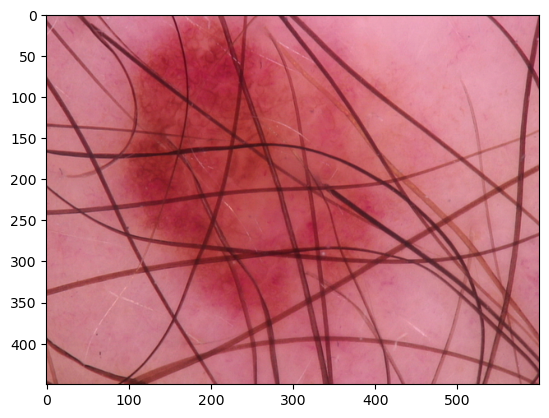

In [40]:
# let's read an hairy image first.
path = '../data/val/nevus/nev07772.jpg'
im = np.array(cv2.imread(path, cv2.IMREAD_COLOR))

im0 =  cv2.cvtColor(im, cv2.COLOR_RGB2BGR)

im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
plt.imshow(im0, cmap='gray')



## Step 1: Apply MF-FDOG filter to detect hairs roughly.

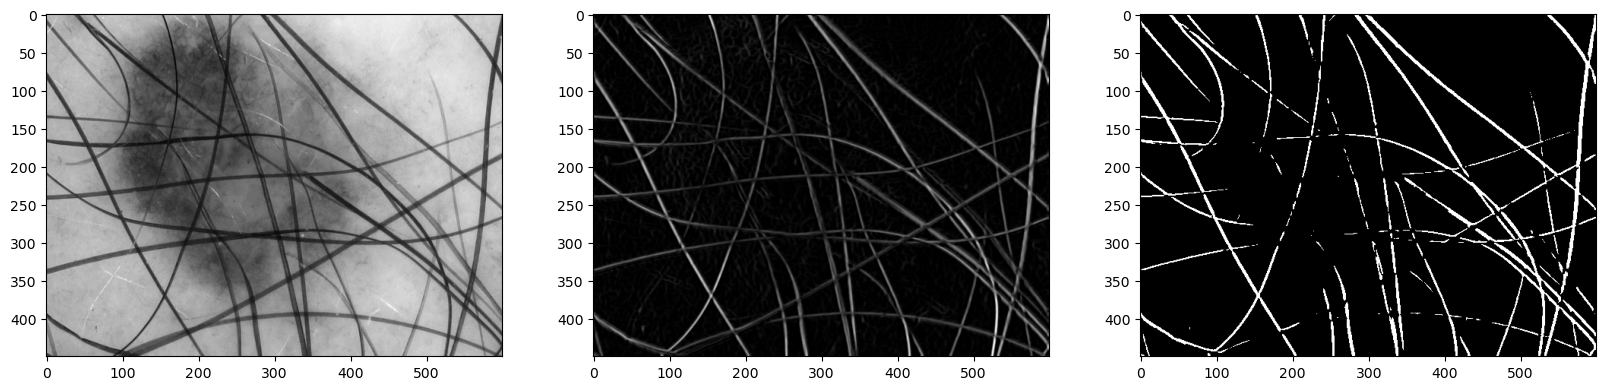

In [13]:
L = 6     # the length of the neighborhood along the y-axis to smooth noise
sigma = 1.5 # (?)# scale
w = 31 # (?)    # kernel size
c = 4 # the gain of threshold
n = 130 # number of pixels to eliminate
rot = 12 # number of rotations

params = [L, sigma, w, c, n, rot]

out, H = f.pipeline(path, params = params, filter_out = False, save=False)

plt.figure(figsize=(20, 15))
plt.set_cmap('gray')
plt.tight_layout()
plt.subplot(1, 3, 1)
plt.imshow(im)
plt.subplot(1, 3, 2)
plt.imshow(H)
plt.subplot(1, 3, 3)
plt.imshow(out)

## Step 2: Refine!

### Step 2.1: Closing

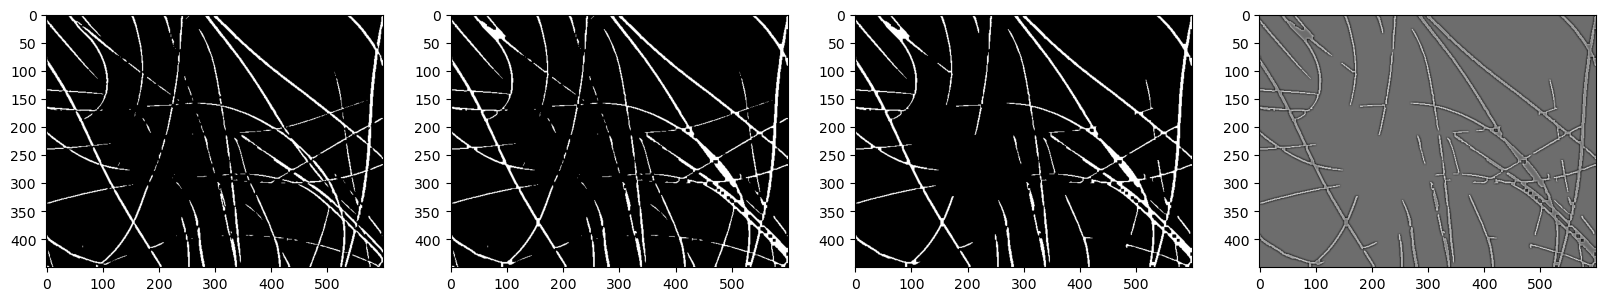

In [59]:
mask, maskf = m.cls(out, r = 5, filter_out= 100, eps=0.01)

maskf_b = cv2.GaussianBlur(maskf,(7,7),cv2.BORDER_DEFAULT)
plt.figure(figsize=(20, 15))
plt.set_cmap('gray')
plt.tight_layout()
plt.subplot(1, 4, 1)
plt.imshow(out)
plt.subplot(1, 4, 2)
plt.imshow(mask)
plt.subplot(1, 4, 3)
plt.imshow(maskf)
plt.subplot(1, 4, 4)
plt.imshow(maskf - maskf_b)

### Step 2.2: Constraint with Haralick Circularity 

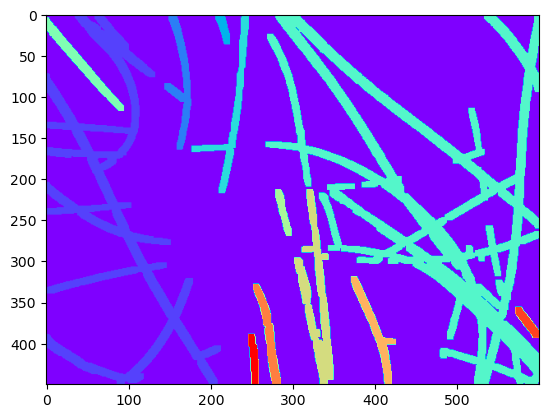

In [60]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(maskf_b.astype(np.uint8), connectivity=4)
plt.imshow(labels, cmap='rainbow')

3.2954142930640824 0.5818632393929737
3.500376703151995 1.1944352459975036
2.946741314516912 1.7344183112471911
2.260047801901043 0.34804143738318816
2.3991544335256934 0.5527101058002936
2.319356483236423 0.337516695990822
3.892087794743813 1.8094794133458079
3.898791615270954 1.4041270435799136
3.9590075830595293 0.8533433416365647
3.6461876716661585 1.1831650448559907
2.394339013165972 1.019006349523449
3.5556655538210244 2.591645258648868


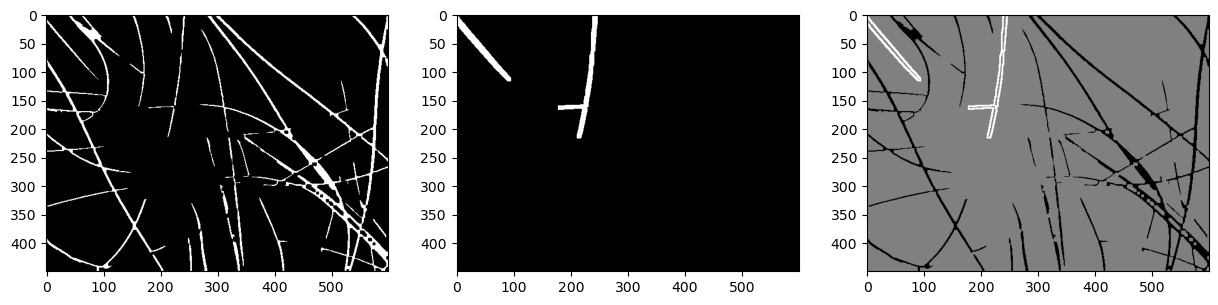

In [61]:
def calc_rdst(x, y, center):
    # calculate the distance metric (rdst) based on (x, y) and center
    return np.sqrt((x - center[0])**2 + (y - center[1])**2)

# min_area_threshold = 1
# fout_labs = np.where(stats[:, cv2.CC_STAT_AREA] >= min_area_threshold)[0]
# labelsf = np.isin(labels, fout_labs).astype(np.uint8)


# loop through each labeled region
hair_labs = []
for label in range(1, num_labels):  # skip the background label (0)
    # create a mask for the current
    label_mask = (labels == label).astype(np.uint8)

    # extract the statistics
    stats_label = stats[label]

    # get the bbox coordinates (x, y, width, height)
    x, y, w, h = stats_label[0], stats_label[1], stats_label[2], stats_label[3]

    # crop the region from the original image
    cropped_region = label_mask[y:y+h, x:x+w]

    center = cropped_region.shape[0] / 2, cropped_region.shape[1] / 2

    y_coords, x_coords = np.where(cropped_region == 1)

    rdst = [calc_rdst(x, y, center = center) for x, y in  zip(x_coords, y_coords)]
    
    hcirc = np.mean(rdst) / np.std(rdst) if np.std(rdst) !=0 else 1 

    # plt.imshow(cropped_region)

    meanc =  hcirc * np.mean(cropped_region)

    print(hcirc, meanc)

    if meanc <= 0.4:
        # assume it is a hair.
        hair_labs.append(label)

hair_mask = np.isin(labels, hair_labs).astype(np.uint8) * 255
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(maskf)
plt.subplot(1, 3, 2)
plt.imshow(hair_mask)
plt.subplot(1, 3, 3)
plt.imshow(hair_mask- maskf)


## Step 3: Superimpose

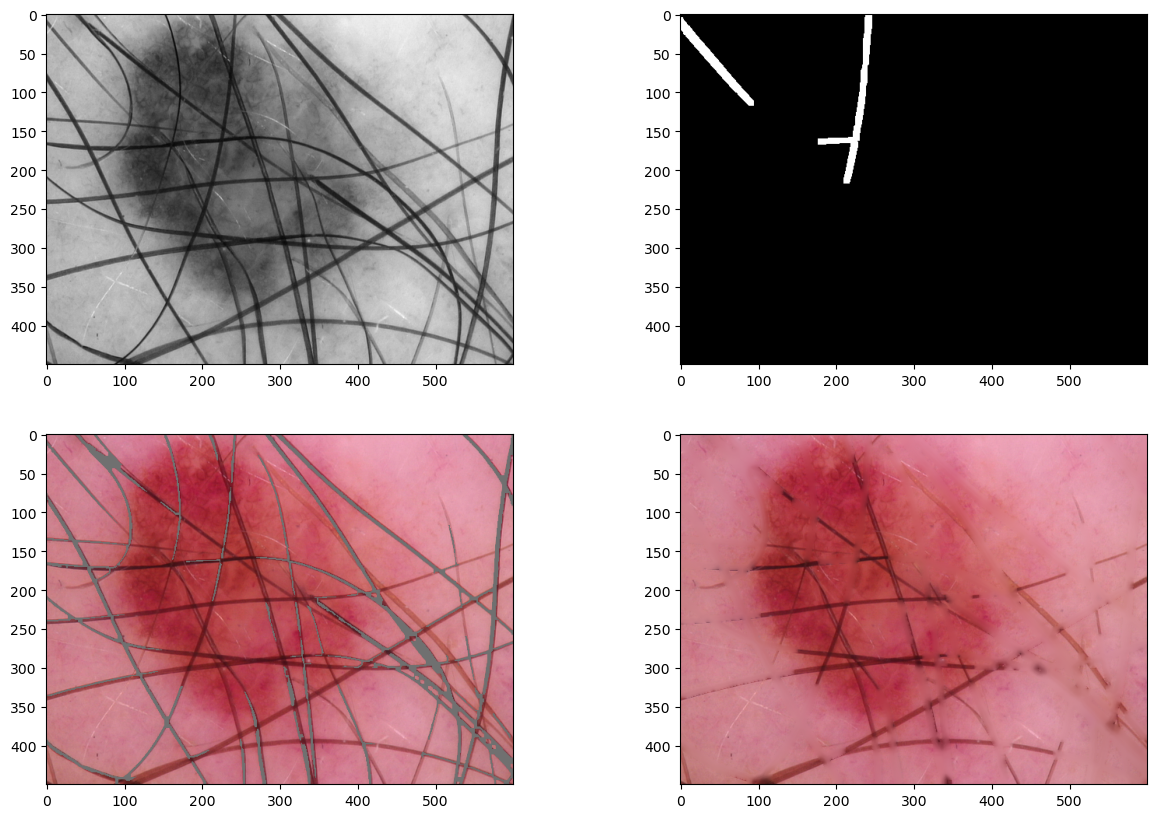

In [62]:
meanm = np.mean(im)

res = im0.copy()

res[maskf > 0] = meanm

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.imshow(im)
plt.subplot(2, 2, 2)
plt.imshow(hair_mask)
plt.subplot(2, 2, 3)
plt.imshow(res)

dst00 = cv2.inpaint(im0, maskf_b.astype(np.uint8), 10, cv2.INPAINT_TELEA)

plt.subplot(2, 2, 4)
plt.imshow(dst00)


## Step 4: Pipeline

nevus nev07772.jpg


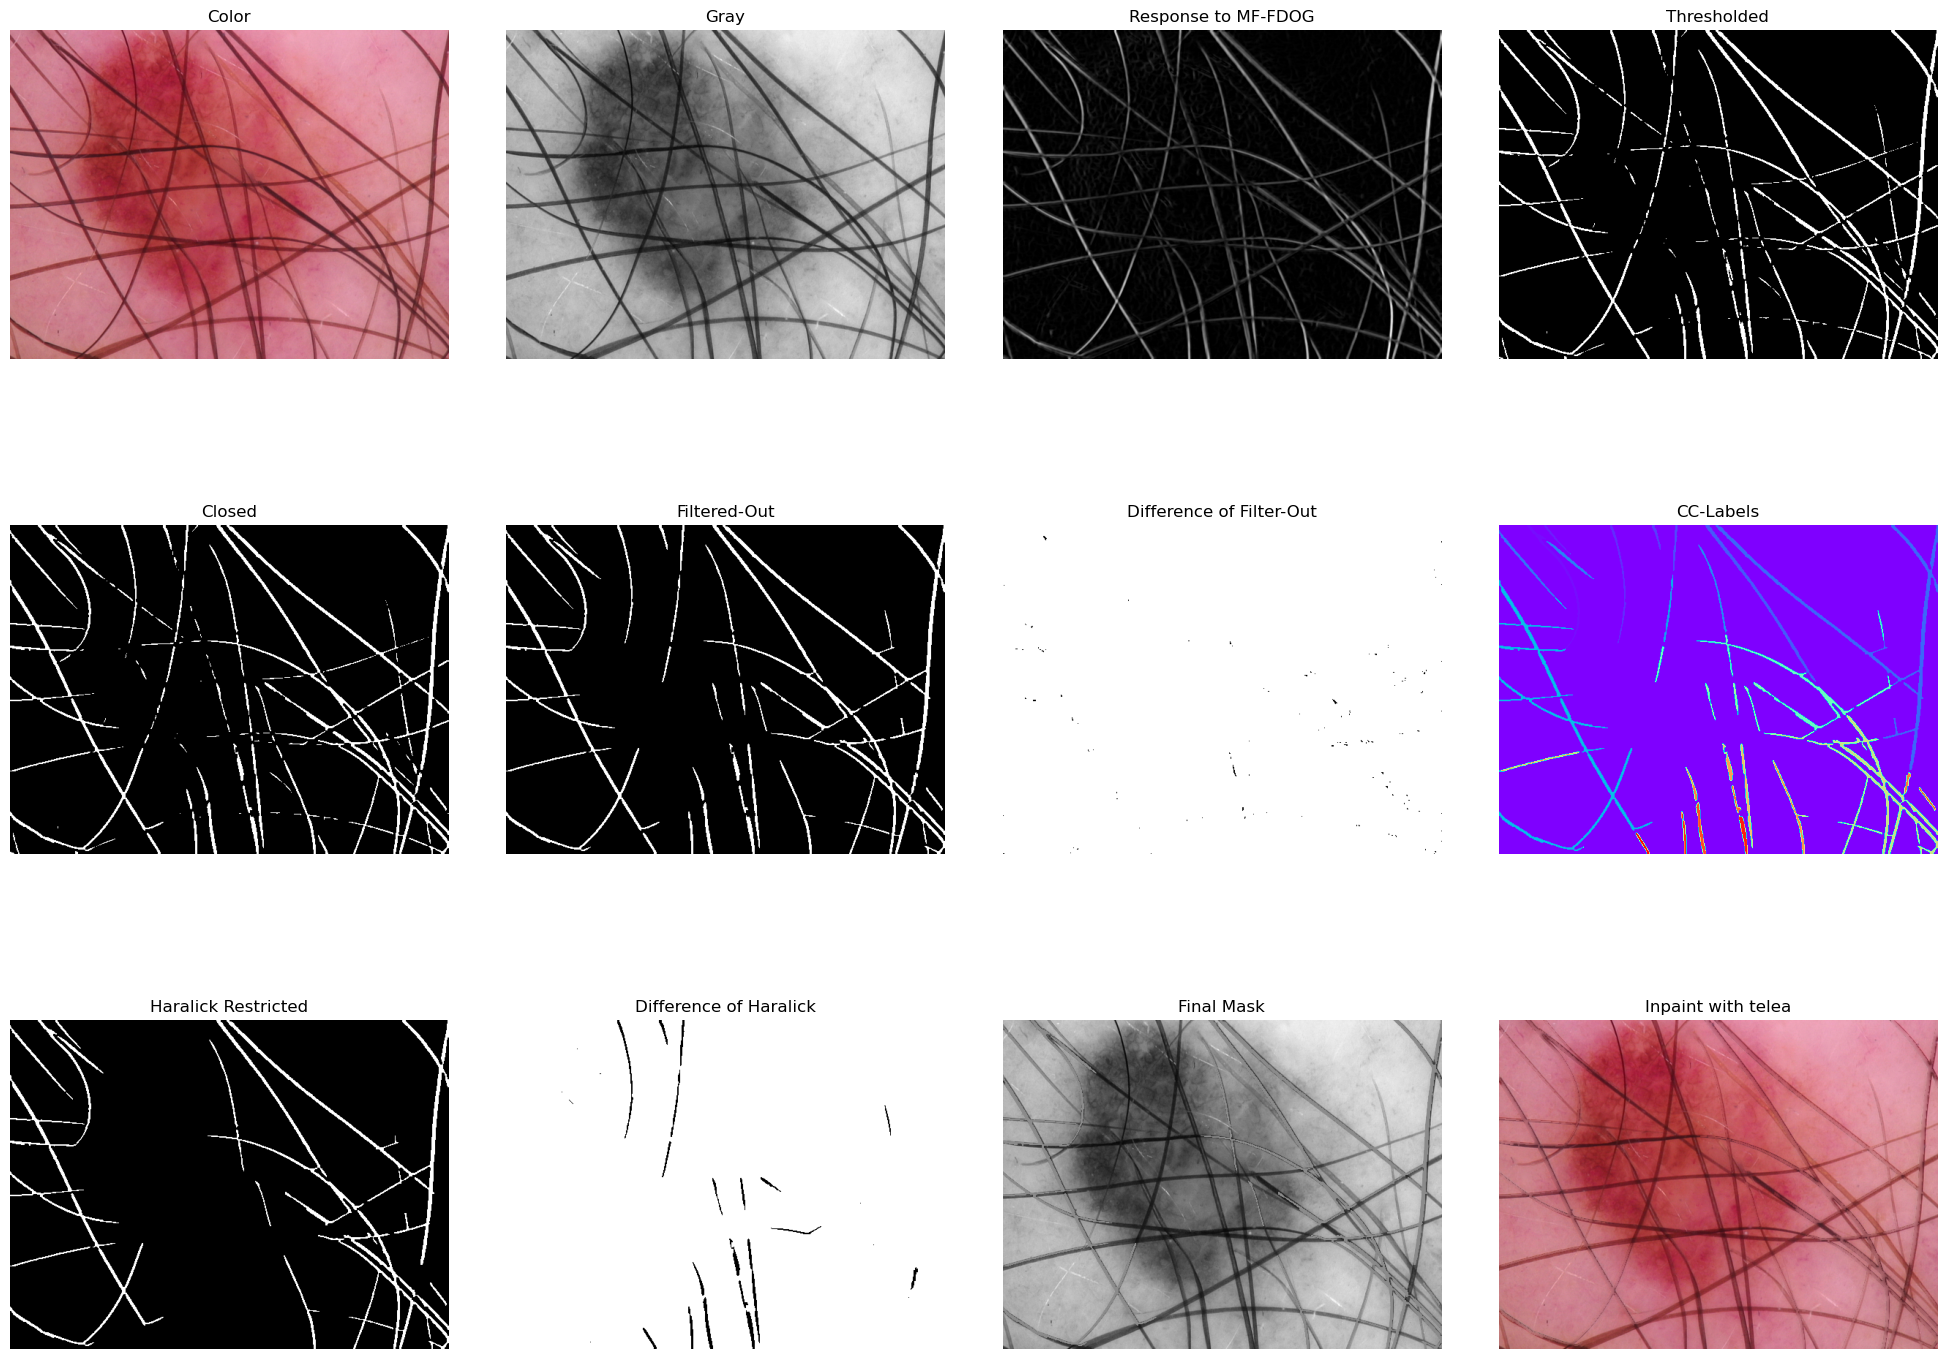

data/preprocessed/val//nevus/nev07772.jpg


In [47]:
def preprocess(path, save = True, out_dir = 'data/preprocessed/val/', show = True, ralg = 'telea'):
    
    lname, fname = path.split('/')[-2:]
    
    print(lname, fname)
    # Step 0.
    im = np.array(cv2.imread(path, cv2.IMREAD_COLOR))

    im0 =  cv2.cvtColor(im, cv2.COLOR_RGB2BGR)

    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

    # Step 1.
    L = 6     # the length of the neighborhood along the y-axis to smooth noise
    sigma = 1.5 # (?)# scale
    w = 31 # (?)    # kernel size
    c = 4 # the gain of threshold
    n = 130 # number of pixels to eliminate
    rot = 12 # number of rotations

    params = [L, sigma, w, c, n, rot]

    out, H = f.pipeline(path, params = params, filter_out = False, save=False)

    # Step 2.
    mask, maskf = m.cls(out, r = 3, filter_out= 100, eps=0.01)


    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(maskf.astype(np.uint8), connectivity=4)

    def calc_rdst(x, y, center):
        # calculate the distance metric (rdst) based on (x, y) and center
        return np.sqrt((x - center[0])**2 + (y - center[1])**2)


    # loop through each labeled region
    hair_labs = []
    for label in range(1, num_labels):  # skip the background label (0)
        # create a mask for the current
        label_mask = (labels == label).astype(np.uint8)

        # extract the statistics
        stats_label = stats[label]

        # get the bbox coordinates (x, y, width, height)
        x, y, w, h = stats_label[0], stats_label[1], stats_label[2], stats_label[3]

        # crop the region from the original image
        cropped_region = label_mask[y:y+h, x:x+w]

        center = cropped_region.shape[0] / 2, cropped_region.shape[1] / 2

        y_coords, x_coords = np.where(cropped_region == 1)

        rdst = [calc_rdst(x, y, center = center) for x, y in  zip(x_coords, y_coords)]
        
        hcirc = np.mean(rdst) / np.std(rdst) if np.std(rdst) !=0 else 1 

        # plt.imshow(cropped_region)

        meanc =  hcirc * np.mean(cropped_region)

        # print(hcirc, meanc)

        if meanc <= 0.4:
            # assume it is a hair.
            hair_labs.append(label)

    # Step 3 Superimpose & Restoration.
    hair_mask = np.isin(labels, hair_labs).astype(np.uint8) * 255

    meanm = np.mean(im)

    res = im.copy()

    res[hair_mask > 0] = meanm


    if ralg == 'telea':
        dst = cv2.inpaint(im0, hair_mask.astype(np.uint8), 10, cv2.INPAINT_TELEA)

    if show:    
        fig, axs = plt.subplots(3, 4, figsize=(20, 15))
        axs = axs.ravel()
        plt.tight_layout()

        images = [im0, im, H, out, mask, maskf, out-mask, labels, hair_mask, hair_mask-maskf, res, dst]
        titles = ['Color', 'Gray', 'Response to MF-FDOG', 'Thresholded', 'Closed', 'Filtered-Out', 'Difference of Filter-Out', 
                'CC-Labels', 'Haralick Restricted', 'Difference of Haralick', 'Final Mask', f'Inpaint with {ralg}']
        
        for i in range(len(axs)):
            if titles[i] == 'CC-Labels':
                axs[i].imshow(images[i], cmap = 'rainbow')
            else:
                axs[i].imshow(images[i])
            axs[i].set_title(titles[i])
            axs[i].axis("off")

        plt.show()

    
    if save:

        out_path = out_dir + '/' + lname + '/' + fname
        print(out_path)
        
        cv2.imwrite(out_path, dst)


    return dst, hair_mask

dst0, mask0 = preprocess(path, ralg = 'telea')



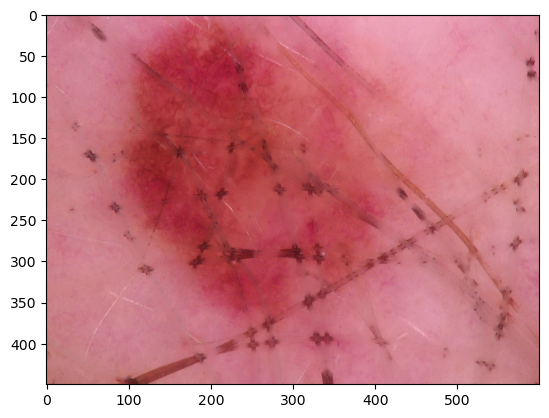

In [37]:

#Gray scale
grayScale = cv2.cvtColor(im0, cv2.COLOR_RGB2GRAY )
#Black hat filter
kernel = cv2.getStructuringElement(1,(9,9)) 
blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
#Gaussian filter
bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
#Binary thresholding (MASK)
ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
#Replace pixels of the mask
dst = cv2.inpaint(im0,mask,6,cv2.INPAINT_TELEA)   

plt.imshow(dst)


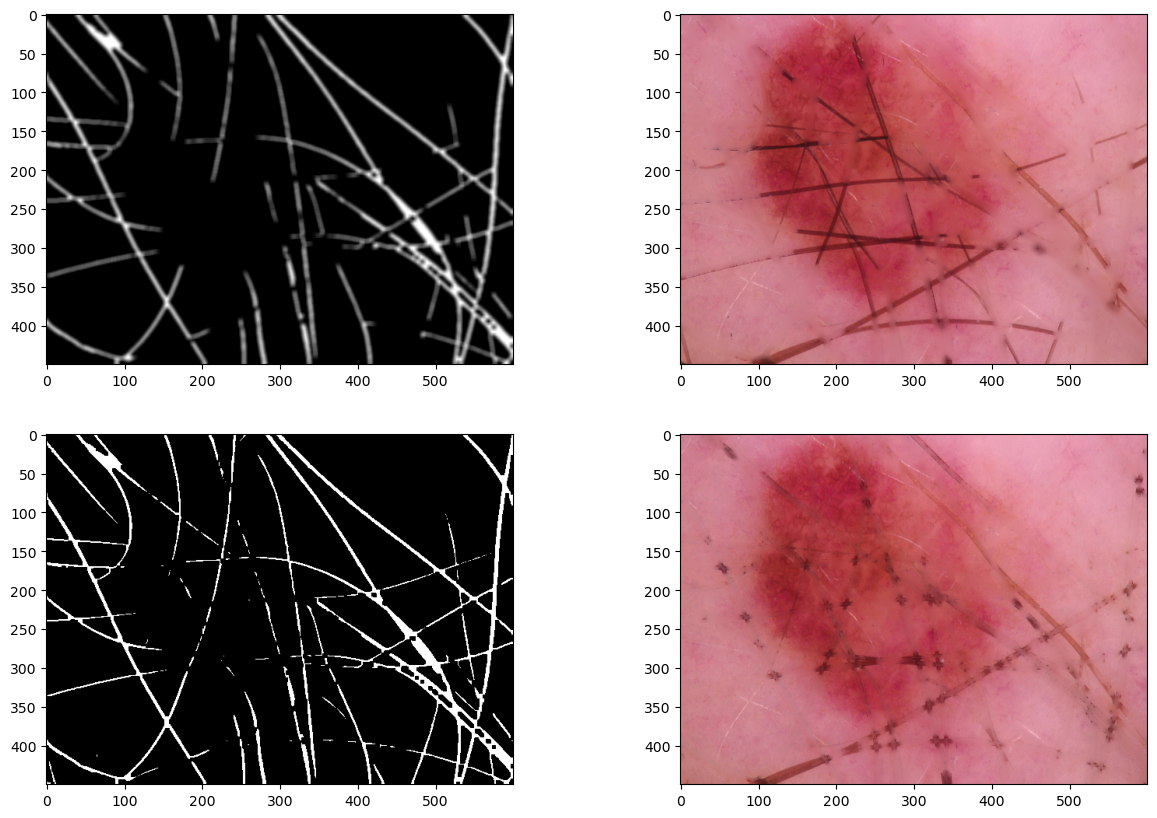

In [63]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.imshow(maskf_b)
plt.subplot(2, 2, 2)
plt.imshow(dst00)
plt.subplot(2, 2, 3)
plt.imshow(mask)
plt.subplot(2, 2, 4)
plt.imshow(dst)